# Train a ConvNet!
We now have a generic solver and a bunch of modularized layers. It's time to put it all together, and train a ConvNet to recognize the classes in CIFAR-10. In this notebook we will walk you through training a simple two-layer ConvNet and then set you free to build the best net that you can to perform well on CIFAR-10.

Open up the file `cs231n/classifiers/convnet.py`; you will see that the `two_layer_convnet` function computes the loss and gradients for a two-layer ConvNet. Note that this function uses the "sandwich" layers defined in `cs231n/layer_utils.py`. 

In [8]:
# As usual, a bit of setup
from IPython.display import Audio, display


import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifier_trainer import ClassifierTrainer
from cs231n.gradient_check import eval_numerical_gradient
from cs231n.classifiers.convnet import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-18, np.abs(x) + np.abs(y))))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from cs231n.data_utils import load_CIFAR10
# Modify load_CIFAR10 and the following function to load less data if you have memory issues.
# Load batches 1, 2 and 3; and call the function as follows:
#def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
def get_CIFAR10_data(num_training=19000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    x_test = X_test.transpose(0, 3, 1, 2).copy()

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (19000, 3, 32, 32)
Train labels shape:  (19000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


# Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [13]:
model = init_two_layer_convnet()

X = np.random.randn(100, 3, 32, 32)
y = np.random.randint(10, size=100)

loss, _ = two_layer_convnet(X, model, y, reg=0)

# Sanity check: Loss should be about log(10) = 2.3026
print 'Sanity check loss (no regularization): ', loss

# Sanity check: Loss should go up when you add regularization
loss, _ = two_layer_convnet(X, model, y, reg=1)
print 'Sanity check loss (with regularization): ', loss

Sanity check loss (no regularization):  2.3026811218810512
Sanity check loss (with regularization):  2.3448267954078124


# Gradient check
After the loss looks reasonable, you should always use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [4]:
num_inputs = 2
input_shape = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_shape)
y = np.random.randint(num_classes, size=num_inputs)

model = init_two_layer_convnet(num_filters=3, filter_size=3, input_shape=input_shape)
loss, grads = two_layer_convnet(X, model, y)
for param_name in sorted(grads):
    f = lambda _: two_layer_convnet(X, model, y)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 4.616875e-07
W2 max relative error: 1.191550e-05
b1 max relative error: 6.948314e-08
b2 max relative error: 2.265571e-07


# Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [5]:
# Use a two-layer ConvNet to overfit 50 training examples.

model = init_two_layer_convnet()
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train[:50], y_train[:50], X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=10, num_epochs=10,
          verbose=True)

starting iteration  0
Finished epoch 0 / 10: cost 2.304314, train: 0.180000, val 0.098000, lr 1.000000e-04
Finished epoch 1 / 10: cost 2.264391, train: 0.260000, val 0.144000, lr 9.500000e-05
Finished epoch 2 / 10: cost 1.952534, train: 0.280000, val 0.151000, lr 9.025000e-05
starting iteration  10
Finished epoch 3 / 10: cost 1.668788, train: 0.480000, val 0.174000, lr 8.573750e-05
Finished epoch 4 / 10: cost 1.222001, train: 0.560000, val 0.169000, lr 8.145062e-05
starting iteration  20
Finished epoch 5 / 10: cost 1.152509, train: 0.320000, val 0.126000, lr 7.737809e-05
Finished epoch 6 / 10: cost 0.879032, train: 0.640000, val 0.180000, lr 7.350919e-05
starting iteration  30
Finished epoch 7 / 10: cost 0.770718, train: 0.760000, val 0.188000, lr 6.983373e-05
Finished epoch 8 / 10: cost 0.311530, train: 0.840000, val 0.190000, lr 6.634204e-05
starting iteration  40
Finished epoch 9 / 10: cost 0.502017, train: 0.900000, val 0.176000, lr 6.302494e-05
Finished epoch 10 / 10: cost 0.16281

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

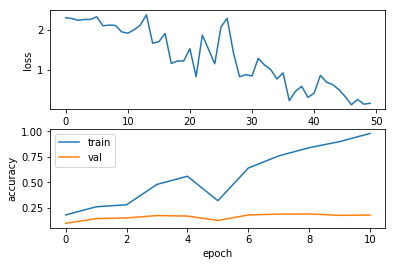

In [6]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Train the net
Once the above works, training the net is the next thing to try. You can set the `acc_frequency` parameter to change the frequency at which the training and validation set accuracies are tested. If your parameters are set properly, you should see the training and validation accuracy start to improve within a hundred iterations, and you should be able to train a reasonable model with just one epoch.

Using the parameters below you should be able to get around 50% accuracy on the validation set.

In [7]:
model = init_two_layer_convnet(filter_size=7)
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=50, num_epochs=1,
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 1: cost 2.299380, train: 0.103000, val 0.113000, lr 1.000000e-04
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 1: cost 2.005473, train: 0.345000, val 0.332000, lr 1.000000e-04
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 1: cost 1.885761, train: 0.408000, val 0.391000, lr 1.000000e-04
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 1: cost 1.804518, train: 0.405000, val 0.398000, lr 1.000000e-04
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
Finished epoch 0 / 1: cost 1.827042, train: 0.450000, val 0.440000, lr 1.000000e-04
starting iteration  210
starting iteration  220
starting iteration  230
starting iterat

# Visualize weights
We can visualize the convolutional weights from the first layer. If everything worked properly, these will usually be edges and blobs of various colors and orientations.

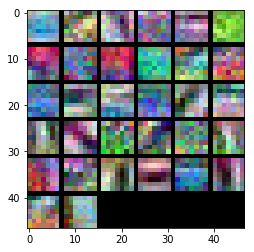

In [8]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))

# Experiment!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:

### Things you should try:
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Network depth: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `cs231n/classifiers/convnet.py`. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum and RMSprop; you could try alternatives like AdaGrad or AdaDelta.
- Other forms of regularization such as L1 or Dropout
- Alternative activation functions such as leaky ReLU or maxout
- Model ensembles
- Data augmentation

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!

#  Results
    
   Given two layer net: 0.440000  
   Same network, filter size is 3: 0.448000  
   Same network, filter size is 5: 0.467000
   best parameters found in sweeping for two layer net:
   lr: 1.000000e-04 reg: 1.000000e-04 m: 9.000000e-01
   
   (conv+relu+pool)x3 - affine - softmax default parameters: 0.107000  
   
   (conv+relu+conv+relu+pool) + affine + softmax default parameters: after a while val_acc is converged  
   and train_acc kept increasing a little. Capacity was not enough parameters are not well tuned yet.
   
   cost 1.067550, train: 0.660000, val 0.527000 
   

In [33]:
model = init_two_layer_convnet(filter_size=5)
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=50, num_epochs=1,
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 1: cost 2.301537, train: 0.105000, val 0.117000, lr 1.000000e-04
starting iteration  10
starting iteration  20
starting iteration  30


cs231n/classifiers/convnet.py:57: RuntimeWarning: invalid value encountered in divide
  # Compute the backward pass


starting iteration  40
starting iteration  50
Finished epoch 0 / 1: cost nan, train: 0.104000, val 0.097000, lr 1.000000e-04
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 1: cost nan, train: 0.106000, val 0.097000, lr 1.000000e-04
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 1: cost nan, train: 0.109000, val 0.097000, lr 1.000000e-04
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
Finished epoch 0 / 1: cost nan, train: 0.122000, val 0.097000, lr 1.000000e-04
starting iteration  210
starting iteration  220
starting iteration  230
starting iteration  240
starting iteration  250
Finished epoch 0 / 1: cost nan, train: 0.104000, val 0.097000, lr 1.000000e-04
starting iteration  260
starting iteration  270
starting iteration  280
starting it

In [31]:
## Sweep through parameters for a model as we did in HW1 
## for 5000 samples, with batch size 50, it makes 100 iterations for each parameters combination

results = {}
best_val = -1
learning_rates = [1, 1.4e-1,1.8e-2, 0.001, 0.0001]
regularization_strengths = [0.1, 0.01, 0.001, 0.0001]
momentum = [0.6,0.75,0.9]
k=0
while k<len(learning_rates):
    i=0
    while i< len(regularization_strengths):
        j = 0
        while j < len(momentum):
            model = init_two_layer_convnet(filter_size=5)
            trainer = ClassifierTrainer()
            best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train[:5000], y_train[:5000], X_val, y_val, model, two_layer_convnet,
          regularization_strengths[i], momentum[j], learning_rates[k], batch_size=50, num_epochs=1,
          acc_frequency=50, verbose=False)

            if best_val < max(val_acc_history):
                best_val = max(val_acc_history)
                best_model = model
            results[(learning_rates[k], regularization_strengths[i],momentum[j])] = (max(train_acc_history), max(val_acc_history))
            j=j+1
        i=i+1
    k=k+1
    
    
for lr, reg, m in sorted(results):
    train_accuracy, val_accuracy = results[(lr,reg,m)]
    print 'lr: %e reg: %e m: %e train accuracy: %f val accuracy: %f' % (
                lr, reg,m, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50


cs231n/layers.py:340: RuntimeWarning: overflow encountered in subtract
  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
cs231n/layers.py:340: RuntimeWarning: invalid value encountered in subtract
  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
cs231n/classifiers/convnet.py:67: RuntimeWarning: overflow encountered in multiply
  reg_loss = 0.5 * reg * sum(np.sum(W * W) for W in [W1, W2])
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
cs231n/layers.py:77: RuntimeWarning: invalid value encountered in less_equal
  x[x<= 0] = 0
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis,

starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iterat

starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iterat

lr: 1.000000e-04 reg: 1.000000e-04 m: 4.000000e-01 train accuracy: 0.102000 val accuracy: 0.097000
lr: 1.000000e-04 reg: 1.000000e-04 m: 7.000000e-01 train accuracy: 0.103000 val accuracy: 0.105000
lr: 1.000000e-04 reg: 1.000000e-04 m: 9.000000e-01 train accuracy: 0.091000 val accuracy: 0.100000
lr: 1.000000e-04 reg: 1.000000e-03 m: 4.000000e-01 train accuracy: 0.103000 val accuracy: 0.106000
lr: 1.000000e-04 reg: 1.000000e-03 m: 7.000000e-01 train accuracy: 0.074000 val accuracy: 0.088000
lr: 1.000000e-04 reg: 1.000000e-03 m: 9.000000e-01 train accuracy: 0.101000 val accuracy: 0.103000
lr: 1.000000e-04 reg: 1.000000e-02 m: 4.000000e-01 train accuracy: 0.112000 val accuracy: 0.098000
lr: 1.000000e-04 reg: 1.000000e-02 m: 7.000000e-01 train accuracy: 0.103000 val accuracy: 0.106000
lr: 1.000000e-04 reg: 1.000000e-02 m: 9.000000e-01 train accuracy: 0.102000 val accuracy: 0.097000
lr: 1.000000e-04 reg: 1.000000e-01 m: 4.000000e-01 train accuracy: 0.112000 val accuracy: 0.098000
lr: 1.0000

In [17]:
model = init_four_layer_convnet(filter_size=5)
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, four_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=50, num_epochs=1,
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 1: cost 2.302615, train: 0.113000, val 0.107000, lr 1.000000e-04
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 1: cost 2.302633, train: 0.096000, val 0.098000, lr 1.000000e-04
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 1: cost 2.302640, train: 0.097000, val 0.099000, lr 1.000000e-04
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 1: cost 2.302669, train: 0.108000, val 0.089000, lr 1.000000e-04
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
Finished epoch 0 / 1: cost 2.302618, train: 0.087000, val 0.098000, lr 1.000000e-04
starting iteration  210
starting iteration  220
starting iteration  230
starting iterat

In [57]:
model = best_model
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, convrelu_convrelupool,
          reg=0.001, momentum=0.9, learning_rate=0.001, batch_size=50, num_epochs=10,
          acc_frequency=50, verbose=True)

Audio(url='http://www.soundjay.com/button/beep-07.wav',autoplay=True) # alarm 

starting iteration  0
Finished epoch 0 / 10: cost 1.423852, train: 0.436000, val 0.417000, lr 1.000000e-03
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 10: cost 1.568594, train: 0.450000, val 0.428000, lr 1.000000e-03
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 10: cost 1.827547, train: 0.453000, val 0.409000, lr 1.000000e-03
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 10: cost 1.280919, train: 0.460000, val 0.445000, lr 1.000000e-03
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
Finished epoch 0 / 10: cost 1.422697, train: 0.494000, val 0.439000, lr 1.000000e-03
starting iteration  210
starting iteration  220
starting iteration  230
starting i

Finished epoch 5 / 10: cost 0.749649, train: 0.671000, val 0.514000, lr 7.737809e-04
starting iteration  1900
Finished epoch 5 / 10: cost 1.062220, train: 0.687000, val 0.509000, lr 7.737809e-04
starting iteration  1910
starting iteration  1920
starting iteration  1930
starting iteration  1940
starting iteration  1950
Finished epoch 5 / 10: cost 1.216624, train: 0.643000, val 0.475000, lr 7.737809e-04
starting iteration  1960
starting iteration  1970
starting iteration  1980
starting iteration  1990
starting iteration  2000
Finished epoch 5 / 10: cost 1.049527, train: 0.629000, val 0.493000, lr 7.737809e-04
starting iteration  2010
starting iteration  2020
starting iteration  2030
starting iteration  2040
starting iteration  2050
Finished epoch 5 / 10: cost 0.796468, train: 0.680000, val 0.489000, lr 7.737809e-04
starting iteration  2060
starting iteration  2070
starting iteration  2080
starting iteration  2090
starting iteration  2100
Finished epoch 5 / 10: cost 0.889006, train: 0.646

KeyboardInterrupt: 

In [61]:
train_acc_history

[0.079, 0.22, 0.29, 0.314, 0.377, 0.353, 0.448, 0.453, 0.441]